In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(7395, 23)
(7395, 4)


In [6]:
min(Y_footsteps_accelerations_absolute[:, 0])

-0.12352446419616336

In [7]:
max(Y_footsteps_accelerations_absolute[:, 0])

0.37898036658079226

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [9]:
# Entries where FL is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_FL_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FL_swinging = Y_footsteps_accelerations_absolute[idxs]

In [10]:
len(idxs)

3698

In [11]:
X_footsteps_accelerations_absolute_FL_swinging[0]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.08173007,  0.01015645,  0.00478749,  0.23448798,
        0.12098632, -0.31370604,  0.26968373, -0.13223646, -0.26779938,
       -0.25294316,  0.13706825, -0.27173775, -0.28294898, -0.12839869,
       -0.31333761,  1.        ,  0.        ])

In [12]:
Y_footsteps_accelerations_absolute[0]

array([ 0.02098461, -0.00857336,  0.01606431,  0.00992814])

## Predict FL foot -> x

### Linear Regression

In [13]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 9:11], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 12:14], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 15:17], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 18:20])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9894042937922372
RMSE:  0.008992049231319806
The lowest error is:  1.8450216820592447e-05
The highest error is:  0.026104117518405412
The avg. error is:  0.0065229917215957525


In [15]:
model_fl_relative_support_x.coef_

array([[ 0.05864138,  0.15598184,  0.01118929, -0.70591832,  0.60924306,
         0.25416503,  0.18869218, -0.29485021, -0.18587403, -0.07650492,
        -0.44277353]])

In [16]:
model_fl_relative_support_x.intercept_

array([-0.06780523])

In [17]:
#inp = np.array([[0.9, 0.661, 0.159, 0.124, 0.331, -0.137, -0.169, 0.119, -0.337, -0.127]])

In [18]:
#out = model_fl_relative_support_x.coef_ @ inp.T
#out += model_fl_relative_support_x.intercept_
#print(out)

Text(0, 0.5, 'Predictions')

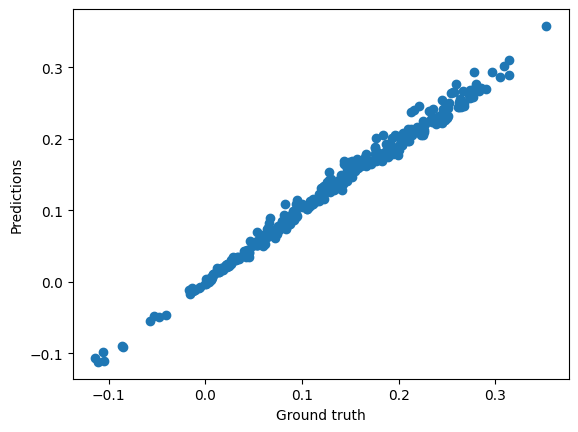

In [19]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 3]}. CoM: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [21]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 9:11], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 12:14], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 15:17], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 18:20])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  0.8212476620058138
RMSE:  0.003755248569313863
The lowest error is:  1.7262181363247864e-05
The highest error is:  0.011479728239258344
The avg. error is:  0.0029675729913655295


In [22]:
model_fl_relative_support_y.coef_

array([[-1.58766540e-02, -2.53719111e-02,  7.94383701e-05,
         6.35806968e-02, -9.49319161e-01, -5.46455329e-01,
        -3.66938028e-02,  6.63295701e-01,  4.28992000e-01,
        -1.11070894e-01,  1.41091622e-01]])

In [23]:
model_fl_relative_support_y.intercept_

array([0.3542387])

Text(0, 0.5, 'Predictions')

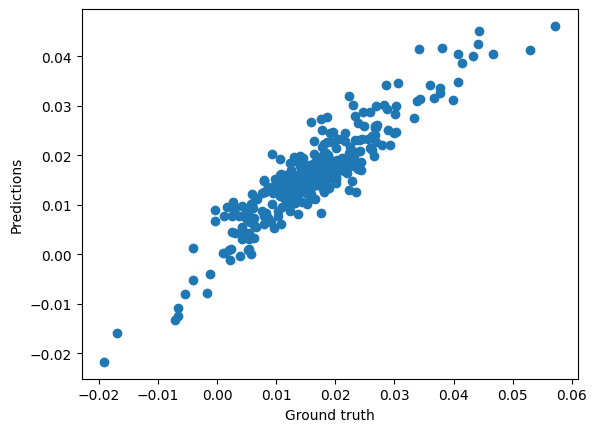

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')